<a href="https://colab.research.google.com/github/kunalburgul/MLDS_Problems/blob/main/The-Kvasir-Capsule/The_Kvasir_Capsule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kvasir-Capsule Disease Classifier

**Content**

The small bowel constitutes the gastrointestinal (GI) tract’s mid-part, situated between the stomach and the large bowel. It is three to four meters long and has a surface of about 30 m^2, including the surface of the villi, and plays a crucial role in absorbing nutrients. Therefore, disorders in the small bowel may cause severe growth retardation in children and nutrient deﬁciencies in children and adults. This organ may be affected by chronic diseases, like Crohn’s disease, coeliac disease, and angiectasis,or malignant diseases like lymphoma and adenocarcinoma. These diseases may represent a substantial health challenge for both patients and society, and a thorough examination of the lumen is frequently necessary to diagnose and treat them. However, the small bowel, due to its anatomical location, is less accessible for inspection by ﬂexible endoscopes commonly used for the upper GI tract and the large bowel. Since early 2000, video capsule endoscopy (VCE) has been used, usually as a complementary test for patients with GI bleeding. A VCE consists of a small capsule containing a wide-angle camera, lightsources, batteries, and other electronics. The patient swallows the capsule, which then captures a video as it moves passively through the GI tract. A recorder, carried by the patient or included in the capsule, stores the video before a medical expert assesses it after the procedure. [Source of information: Reasearch paper: Kvasir-Capsule, a video capsule endoscopy dataset]

**Problem Statement**
 
Artificial intelligence (AI) is predicted to have profound effects on the future of video capsule endoscopy (VCE) technology.The potential lies in improving anomaly detection while reducing manual labour. However, medical data is often sparse and unavailable to the research community, and qualified medical personnel rarely have time for the tedious labelling work.

**Objective**

Build a model to recognize the disease label of the respective images


## Getting the dataset



Getting the dataset using the link - id of the data through the gdown function and storing the dataset in the data.zip file.

In [ ]:
# !gdown --id 1yDcNMTI-8Zq2Mvs8qe7pLNpPx4BW5Yta --output /content/data.zip

Extracting the data.zip file 

In [ ]:
# %%capture
# !unzip /content/data.zip

After extraction of the data.zip file we got the whole data in the following file - "The Kvasir-Capsule"

## Data Preprocessing



In [ ]:
# Importing the necessary libraries
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

### Data Exploration 

Let's see what all file do we have 

In [ ]:
!ls /content/

 data.zip   sample_data  'The Kvasir-Capsule'


Exploring the contents of the dataset

In [ ]:
%cd /content/The\ Kvasir-Capsule
print("-------")
!ls
print("-------")

/content/The Kvasir-Capsule
-------
sample_submission.csv  test  Testing_set.csv  train  Training_set.csv
-------


In [ ]:
%%capture
%cd /content/
data_dir = "/content/The Kvasir-Capsule"

In [ ]:
files = os.listdir(data_dir+ "/train")
files[:5]

['Image_521.jpg',
 'Image_36964.jpg',
 'Image_23363.jpg',
 'Image_31324.jpg',
 'Image_9780.jpg']

As there are the two folder containing images. Let's explore how many image do we have each of this dataset directories.

In [ ]:
# Let's explore the training set.csv and testing_set.csv
train_files = os.listdir(data_dir + "/train")
print('No. of train data examples:', len(train_files))
test_files = os.listdir(data_dir + "/test")
print('No. of test data examples:', len(test_files))

No. of train data examples: 37790
No. of test data examples: 9448


In [ ]:
# Reading the csv file for data labelling
train_set = pd.read_csv('/content/The Kvasir-Capsule/Training_set.csv')
test_set = pd.read_csv('/content/The Kvasir-Capsule/Testing_set.csv')

In [ ]:
!ls

 data.zip   sample_data  'The Kvasir-Capsule'


In [ ]:
train_set.head()

,filename,label
0,Image_1.jpg,Normal clean mucosa
1,Image_2.jpg,Normal clean mucosa
2,Image_3.jpg,Foreign body
3,Image_4.jpg,Normal clean mucosa
4,Image_5.jpg,Normal clean mucosa


In [ ]:
test_set.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


As we could observe the train_set there are two features named as **filename** and **label**.

- Here the first feature **filename** follows to the name of images present in the train folder and  
- the second feature **label** represent the name of the class that image belongs one of the cateogry from the list of classes. 

All parts of the GI tract can be affected by abnormalities or findings due to disease, and the small bowel is no exception.
Abnormalities, called **pathological findings**, in the small bowel can be seen both as irregular content in the mucosal lumen or as
changes to the mucosal surface. These findings are classified according to the Minimal Standard Terminology, defined by the
World Endoscopy Organization.

Now let's get all the unique classes from the train.csv where these classes represents as the labels to the images present in the train folder. 

In [ ]:
train_set['label'].unique(), len(train_set['label'].unique())

(array(['Normal clean mucosa', 'Foreign body', 'Reduced mucosal view',
        'Ileocecal valve', 'Lymphangiectasia', 'ulcer', 'Angiectasia',
        'Pylorus', 'Erosion', 'Blood - fresh', 'Erythema', 'Polyp',
        'ampulla_of_vater', 'Blood - hematin'], dtype=object), 14)

It can be observed that this images were classifed into 14 different categories and now let's explore the counts of this images in each class.

In [ ]:
train_set['label'].value_counts()

Normal clean mucosa     27470
Ileocecal valve          3351
Reduced mucosal view     2325
Pylorus                  1223
Angiectasia               693
ulcer                     683
Foreign body              621
Lymphangiectasia          473
Erosion                   405
Blood - fresh             357
Erythema                  127
Polyp                      44
Blood - hematin            10
ampulla_of_vater            8
Name: label, dtype: int64

As we don't have the train folder data with proper labeled structure for using the *ImageFolder* library to automatically preprocess, we will be manually setting up the numerical value to all the unique labels so that this can be mapped to all the images accordingly for the further processing.

In [ ]:
# Assigning the numercal value to the labels

train_set_classes = train_set['label'].unique()

train_set_order = {
    'Normal clean mucosa':0,
    'Ileocecal valve':1,
    'Reduced mucosal view':2,
    'Pylorus':3,
    'Angiectasia':4,
    'ulcer':5,
    'Foreign body':6,
    'Lymphangiectasia':7,
    'Erosion':8,
    'Blood - fresh':9,
    'Erythema':10,
    'Polyp':11,
    'Blood - hematin':12,
    'ampulla_of_vater':13}

train_set['label'] = train_set.label.map(train_set_order)
train_set_order

{'Angiectasia': 4,
 'Blood - fresh': 9,
 'Blood - hematin': 12,
 'Erosion': 8,
 'Erythema': 10,
 'Foreign body': 6,
 'Ileocecal valve': 1,
 'Lymphangiectasia': 7,
 'Normal clean mucosa': 0,
 'Polyp': 11,
 'Pylorus': 3,
 'Reduced mucosal view': 2,
 'ampulla_of_vater': 13,
 'ulcer': 5}

Above dictonary `train_set_order` represent all the classes that will be mapped to the following numerical values.




Let's view the images contained in the train folder 

In [ ]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

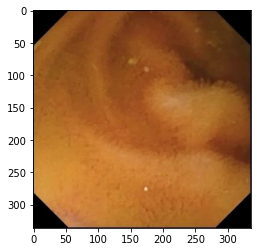

In [ ]:
plt.imshow(open_image(os.path.join(data_dir + "/train", files[0])))

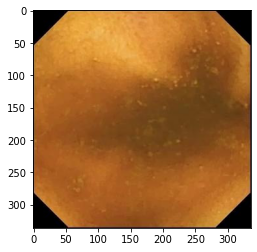

In [ ]:
plt.imshow(open_image(os.path.join(data_dir + "/train", files[1])))

Now let's create a `ImageClassMapper` *class* where we will create a function that will help us to map the numerical value of the label to the images.

In [ ]:
# Function for mapping the labels to the images 
class ImageClassMapper(Dataset):
    def __init__(self, data, path , transform):
        super().__init__()
        self.data = data.values
        self.path = path
        self.classes = train_set_classes
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
      
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
trfm = tt.Compose([tt.ToPILImage(),
                   tt.Resize(img_size), 
                   tt.Pad(8, padding_mode='reflect'),
                   tt.RandomCrop(img_size), 
                   tt.ToTensor(), 
                   tt.Normalize(*imagenet_stats)])

In [ ]:
test_trfm = tt.Compose([tt.ToPILImage(),
                        tt.ToTensor(), 
                        tt.Normalize(*imagenet_stats)])

In [ ]:
dataset = ImageClassMapper(train_set, data_dir + "/train",trfm)

In [ ]:
test_dataset = ImageClassMapper(test_set, data_dir+'/test', test_trfm)

In [ ]:
len(dataset)

37790

In [ ]:
len(test_dataset)

9448

In [ ]:
dataset.classes, len(dataset.classes)

(array(['Normal clean mucosa', 'Foreign body', 'Reduced mucosal view',
        'Ileocecal valve', 'Lymphangiectasia', 'ulcer', 'Angiectasia',
        'Pylorus', 'Erosion', 'Blood - fresh', 'Erythema', 'Polyp',
        'ampulla_of_vater', 'Blood - hematin'], dtype=object), 14)

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [ ]:
def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: Normal clean mucosa (0)


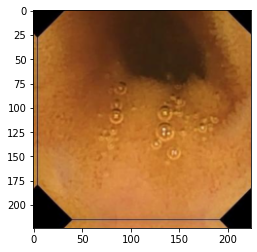

In [ ]:
show_image(*dataset[35])

### Creating the Training and Validation Sets

In [ ]:
from torch.utils.data import random_split

val_pct = 0.2
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [ ]:
len(train_ds), len(valid_ds)

(30232, 7558)

In [ ]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

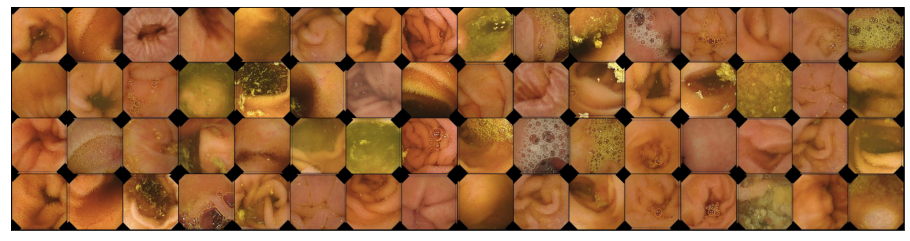

In [ ]:
show_batch(train_dl)

## Modifying a Pretrained Model (ResNet34)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torchvision import models

class DiseasesModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

GPU Utilities and Training Loop


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [ ]:
model = DiseasesModel(len(dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.04829994961619377, 'val_loss': 3.701639413833618}]

In [ ]:
epochs = 15
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00015, train_loss: 0.7566, val_loss: 0.1597, val_acc: 0.9556



Epoch [1],last_lr: 0.00044, train_loss: 0.1025, val_loss: 0.5176, val_acc: 0.8695



Epoch [2],last_lr: 0.00076, train_loss: 0.1322, val_loss: 0.4082, val_acc: 0.8924



Epoch [3],last_lr: 0.00097, train_loss: 0.0957, val_loss: 0.6346, val_acc: 0.8363



Epoch [4],last_lr: 0.00099, train_loss: 0.0821, val_loss: 0.4928, val_acc: 0.8660



Epoch [5],last_lr: 0.00095, train_loss: 0.0814, val_loss: 0.1662, val_acc: 0.9529



Epoch [6],last_lr: 0.00087, train_loss: 0.0343, val_loss: 0.1772, val_acc: 0.9543



Epoch [7],last_lr: 0.00075, train_loss: 0.0277, val_loss: 0.0756, val_acc: 0.9790



Epoch [8],last_lr: 0.00061, train_loss: 0.0220, val_loss: 0.0721, val_acc: 0.9803



Epoch [9],last_lr: 0.00046, train_loss: 0.0083, val_loss: 0.0309, val_acc: 0.9916



Epoch [10],last_lr: 0.00032, train_loss: 0.0025, val_loss: 0.0344, val_acc: 0.9914



Epoch [11],last_lr: 0.00019, train_loss: 0.0032, val_loss: 0.0320, val_acc: 0.9922



Epoch [12],last_lr: 0.00009, train_loss: 0.0014, val_loss: 0.0277, val_acc: 0.9932



Epoch [13],last_lr: 0.00002, train_loss: 0.0010, val_loss: 0.0311, val_acc: 0.9925



Epoch [14],last_lr: 0.00000, train_loss: 0.0013, val_loss: 0.0305, val_acc: 0.9931
CPU times: user 5min 35s, sys: 4min 24s, total: 9min 59s
Wall time: 22min 59s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

NameError: ignored

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

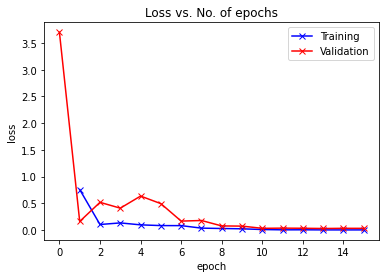

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

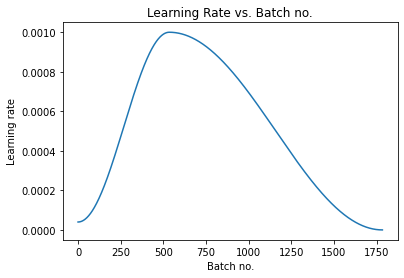

In [ ]:
plot_lrs(history)

In [ ]:
!nvidia-smi

Mon Jun 28 12:17:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    38W / 250W |  15673MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Testing with individual images

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[2].item()]

In [ ]:
valid_ds[2]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [ ]:
def show_image(val_img, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    val_img = denormalize(val_img, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(val_img)

Label: Blood - fresh (9)


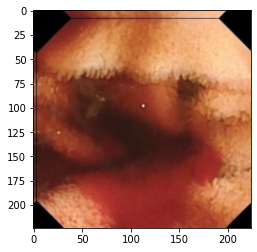

In [ ]:
show_image(*valid_ds[4])

## Checking out on test data


In [ ]:
def predict_image(test_img, model):
    # Convert to a batch of 1
    xb = to_device(test_img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[2].item()]

In [ ]:
def show_image(test_img, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    test_img = denormalize(test_img, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(test_img)

In [ ]:
show_image(*test_dataset[2])

ValueError: ignored

In [ ]:
test_dataset[2]

ValueError: ignored